In [ ]:
import math
import matplotlib.pyplot as plt

import torch

import pennylane as qml
from pennylane import numpy as np
import sklearn

import time
import warnings
warnings.filterwarnings("ignore")

# print(torch.backends.mps.is_available())
# print(torch.backends.mps.is_built())

In [2]:
# device = torch.device("mps" if torch.mps.is_available() else "cpu")
device = torch.device("cpu")
device

device(type='cpu')

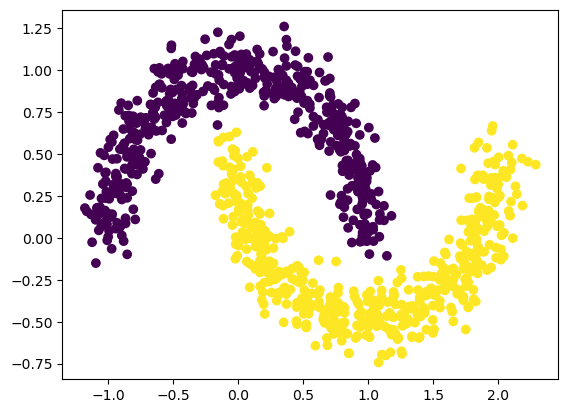

In [10]:
from torch.utils.data import DataLoader, TensorDataset
from sklearn.datasets import make_moons

# Generate and preprocess the dataset
dataset = {}
train_input, train_label = make_moons(n_samples=1000, shuffle=True, noise=0.1, random_state=None)
test_input, test_label = make_moons(n_samples=1000, shuffle=True, noise=0.1, random_state=None)

dtype = torch.get_default_dtype()
torch.set_default_dtype(dtype)
dataset['train_input'] = torch.from_numpy(train_input).type(dtype).to(device)
dataset['test_input'] = torch.from_numpy(test_input).type(dtype).to(device)
dataset['train_label'] = torch.from_numpy(train_label[:, None]).type(dtype).to(device)
dataset['test_label'] = torch.from_numpy(test_label[:, None]).type(dtype).to(device)

# Visualize the dataset
X = dataset['train_input']
y = dataset['train_label']
plt.show()
plt.scatter(X[:,0].cpu().detach().numpy(), X[:,1].cpu().detach().numpy(), c=y[:,0].cpu().detach().numpy())
plt.show()


batch_size = 100
train_loader = torch.utils.data.DataLoader(list(zip(X, y)), batch_size=batch_size, shuffle=True)


X_test = dataset['test_input']
Y_test = dataset['test_label']
test_loader = torch.utils.data.DataLoader(list(zip(X_test, Y_test)), batch_size=batch_size, shuffle=False)


In [8]:
X0list = []
X1list = []
for x,y in train_loader:
    X0 = x[np.where(y==0.)[0]]
    X1 = x[np.where(y==1.)[0]]
    for element in X0:
        element /= torch.norm(element)
        rho = torch.outer(element.conj(), element)
        X0list.append(rho)
    for element in X1:
        element /= torch.norm(element)
        rho = torch.outer(element.conj(), element)
        X1list.append(rho)

rhox0 = torch.mean(torch.stack(X0list), dim=0)
rhox1 = torch.mean(torch.stack(X1list), dim=0)
tr = torch.trace(np.abs(rhox0 - rhox1)) * 0.5
helm_bound = 0.5 + (0.5 * tr)
print("Helm Bound:", helm_bound.item())

Helm Bound: 0.6200625896453857


In [11]:
total_qubits = 4
folds = 4
dev = qml.device("lightning.qubit", wires=total_qubits, c_dtype=np.complex64)

def strongly_entangling_layer(params, total_qubits=total_qubits):

    for i in range(total_qubits):
        qml.RY(params[i], wires=[i])
    for i in range(total_qubits - 1):
        qml.CNOT(wires=[i, i + 1])
    qml.CNOT(wires=[total_qubits - 1, 0])



@qml.qnode(dev, interface="torch")
def circuit(data_point, params, folds=folds):
    ## Aplitude Embedding of the datapoint
    # qml.AmplitudeEmbedding(features=data_point, wires=[0], pad_with=0., normalize=True)
    qml.AngleEmbedding(features=data_point, wires=range(2), rotation="X")

    for i in range(folds):
        strongly_entangling_layer(params[i], total_qubits=total_qubits)

    output = qml.expval(qml.PauliZ(wires=[0]))

    return output

In [12]:
class BatchLossModel(torch.nn.Module):

    def __init__(self, params):
        super().__init__()
        self.params = params

    def forward(self,x):
        # outputs = []
        # for i in range(x.shape[0]):
        #     result = circuit(x[i].cpu(), self.params.cpu())
        #     outputs.append(result.to(dtype=dtype, device=device))

        # return torch.stack(outputs).to(dtype=dtype, device=device)

        outputs = torch.stack([circuit(x[i].cpu(), self.params.cpu()) for i in range(x.shape[0])])
        return outputs.to(device, dtype=dtype)

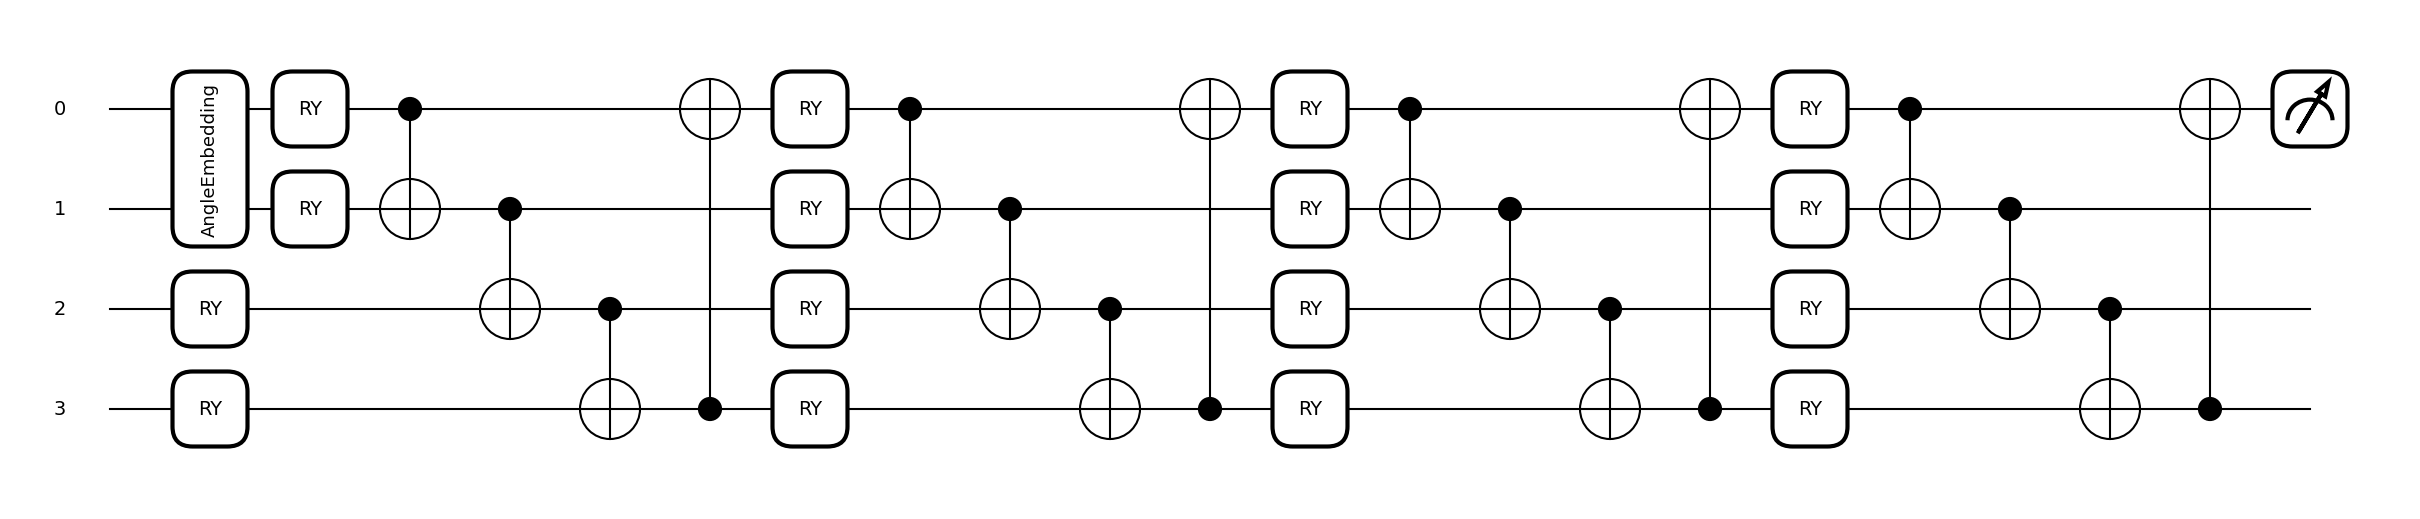

In [13]:
input_params = torch.rand((folds, total_qubits), requires_grad=True, dtype=dtype, device=device)

qml.draw_mpl(circuit, device='default')(X[0],input_params)
plt.show()

In [15]:
weights = input_params
lr = 0.01

model = BatchLossModel(weights)
opt = torch.optim.Adam([weights], lr=lr)
loss_fn = torch.nn.BCEWithLogitsLoss()

loss_history = []
min_loss = float('inf')
optimal_params = torch.zeros((folds, total_qubits), dtype=dtype, device=device)
n_epochs = 20
i = 0

while i < n_epochs:
    running_loss = 0.0

    start_time = time.time()
    for batch_x, batch_y in train_loader:
        
        opt.zero_grad()
        circuit_outputs = (model(batch_x) + 1)/2
        loss = loss_fn(circuit_outputs, batch_y.squeeze(1))
        loss.backward()
        # print("Grad norm:", model.params.grad.norm().item())
        # print("Grad:", model.params.grad)
        opt.step()

        running_loss += loss.item()
    end_time = time.time()

    print(f"Epoch: {i+1} Loss: {running_loss} Time taken per epoch: {end_time - start_time} seconds")

    i += 1
    loss_history.append(running_loss)
    if running_loss < min_loss:
        min_loss = running_loss
        optimal_params = weights.detach().clone()

Epoch: 1 Loss: 7.200060188770294 Time taken per epoch: 3.7080419063568115 seconds
Epoch: 2 Loss: 7.101303935050964 Time taken per epoch: 3.542807102203369 seconds
Epoch: 3 Loss: 6.987419486045837 Time taken per epoch: 3.6129820346832275 seconds
Epoch: 4 Loss: 6.8845741748809814 Time taken per epoch: 3.672834634780884 seconds
Epoch: 5 Loss: 6.821986377239227 Time taken per epoch: 3.6159050464630127 seconds
Epoch: 6 Loss: 6.7748178243637085 Time taken per epoch: 3.605046033859253 seconds
Epoch: 7 Loss: 6.726010322570801 Time taken per epoch: 3.5284359455108643 seconds
Epoch: 8 Loss: 6.698335647583008 Time taken per epoch: 3.5383460521698 seconds
Epoch: 9 Loss: 6.68136066198349 Time taken per epoch: 3.5997960567474365 seconds
Epoch: 10 Loss: 6.670433163642883 Time taken per epoch: 3.5429940223693848 seconds
Epoch: 11 Loss: 6.666219890117645 Time taken per epoch: 3.581987142562866 seconds
Epoch: 12 Loss: 6.6636887192726135 Time taken per epoch: 3.5363309383392334 seconds
Epoch: 13 Loss: 6.

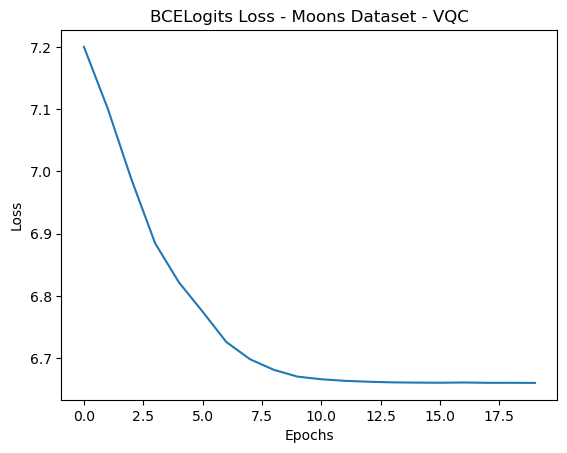

In [16]:
plt.plot(loss_history)

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('BCELogits Loss - Moons Dataset - VQC')
plt.show()

In [17]:
from sklearn.metrics import accuracy_score


model.eval()

all_train_preds = []
all_train_labels = []

with torch.no_grad(): 
    for batch_x, batch_y in train_loader:
        
        outputs = model(batch_x)
        preds = torch.sigmoid(outputs) > 0.5

        all_train_preds.append(preds.cpu())
        all_train_labels.append(batch_y.squeeze(1).cpu())

all_train_preds = torch.cat(all_train_preds)
all_train_labels = torch.cat(all_train_labels)


train_accuracy = accuracy_score(all_train_labels.numpy(), all_train_preds.numpy())

print(f"Train Accuracy: {train_accuracy * 100}%")

Train Accuracy: 50.3%


In [18]:
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for batch_x, batch_y in test_loader:

        outputs = model(batch_x)
        preds = torch.sigmoid(outputs) > 0.5
        all_preds.append(preds.cpu())
        all_labels.append(batch_y.squeeze(1).cpu())

all_preds = torch.cat(all_preds)
all_labels = torch.cat(all_labels)

accuracy = accuracy_score(all_labels.numpy(), all_preds.numpy())    
print(f"Test Accuracy: {accuracy * 100}%")

Test Accuracy: 50.1%
